# Multi Star - Spectroscopic Observables

This notebook shows how you can use the `MultieStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [30]:
import numpy as np
import numpyro
import arviz as az
import matplotlib.pyplot as plt

from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive, init_to_median, init_to_value
from numpyro.infer.reparam import LocScaleReparam

# numpyro.set_host_device_count(10)
# numpyro.enable_x64()
numpyro.set_host_device_count(2)

Then, import the `MultiStarModel` from `celestify`.

In [31]:
from celestify.numpyro_models import MultiStarModel

## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [32]:
rng = random.PRNGKey(0)  # create random key to use throughout notebook
num_stars = 100

rng, key = random.split(rng)
true_model = MultiStarModel(num_stars)

# This samples from the true model given some random key
true_trace = handlers.trace(
    handlers.seed(true_model, key)
).get_trace()
truths = {key: param["value"] for key, param in true_trace.items()}
pprint(truths)

{'M_H': Array([-0.05852471,  0.29938096,  0.45653626, -0.1133469 ,  0.06757239,
       -0.0737225 , -0.47584108, -0.52812016, -0.3928327 , -0.11304975,
       -0.16834386,  0.14935668,  0.33758435, -0.5852516 ,  0.1588056 ,
       -0.81812686,  0.29135802,  0.04957506, -0.48566988, -0.31390327,
       -0.49888727,  0.11274933,  0.23065153, -0.2593057 ,  0.11161698,
        0.469574  ,  0.23121992,  0.21550098, -0.81805784,  0.2740109 ,
        0.42252997, -0.01271057,  0.20286229, -0.5672766 ,  0.09181675,
        0.17507511, -0.45939076,  0.37158176,  0.21159014, -0.14957501,
       -0.22984469,  0.37023804,  0.1232456 ,  0.22394349,  0.0178478 ,
       -0.29741755,  0.21600655,  0.46899495, -0.33753276, -0.30574623,
       -0.6053035 , -0.34464929,  0.2859962 ,  0.13799107, -0.08961608,
       -0.04843568, -0.53518355, -0.594525  ,  0.28947616,  0.42599723,
       -0.17077687, -0.2812849 ,  0.14537197, -0.56235707,  0.41734427,
        0.15343332,  0.31645402, -0.615486  ,  0.1605707

## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [33]:
rng, key = random.split(rng)

sigma_mh = 0.1
mu_mh = truths["M_H"] + sigma_mh * random.normal(key, shape=truths["M_H"].shape)  # add noise to metallicity prior

# Create dictionary of model constants
const = {
    "M_H": dict(loc=mu_mh, scale=sigma_mh),
    "Teff": dict(scale=100.),
    "log_g": dict(scale=0.1),
}

# Create model
model = MultiStarModel(num_stars, const=const)

pprint(model.const)  # check all constants

{'M_H': {'loc': Array([ 0.14131176,  0.2105041 ,  0.48892915,  0.04063462,  0.05545193,
       -0.30229518, -0.58149475, -0.5149886 , -0.30268463, -0.06423257,
       -0.1942823 ,  0.1846254 ,  0.21212378, -0.7798928 ,  0.18645622,
       -0.907997  ,  0.3969591 ,  0.02627089, -0.44696265, -0.29089582,
       -0.53529   ,  0.25025633,  0.3152387 , -0.2371198 ,  0.10377225,
        0.41918382,  0.19135725,  0.35119453, -0.9151819 ,  0.23455125,
        0.518436  ,  0.17132275,  0.18670212, -0.6563551 ,  0.04200224,
        0.12581095, -0.4018562 ,  0.22067477,  0.3788947 , -0.17280787,
       -0.23823756,  0.2057545 ,  0.09299935,  0.15394437,  0.1812813 ,
       -0.34492183,  0.16538182,  0.53276193, -0.24621344, -0.44526267,
       -0.6609701 , -0.5069589 ,  0.1264586 ,  0.15216292,  0.03428263,
       -0.07217786, -0.5692675 , -0.6355188 ,  0.29949287,  0.42744112,
       -0.16338587, -0.3711251 ,  0.15249963, -0.5944764 ,  0.50606257,
        0.17315707,  0.40608412, -0.51568824,  0

## Prior Predictive

Sample from the model prior.

In [34]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=2000)
prior_samples = prior_predictive(key)

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [35]:
coords = {"star": np.arange(num_stars)}
dims = {key: ["star"] for key, value in prior_samples.items() if value.ndim > 1}
data = az.from_numpyro(prior=prior_samples, coords=coords, dims=dims)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

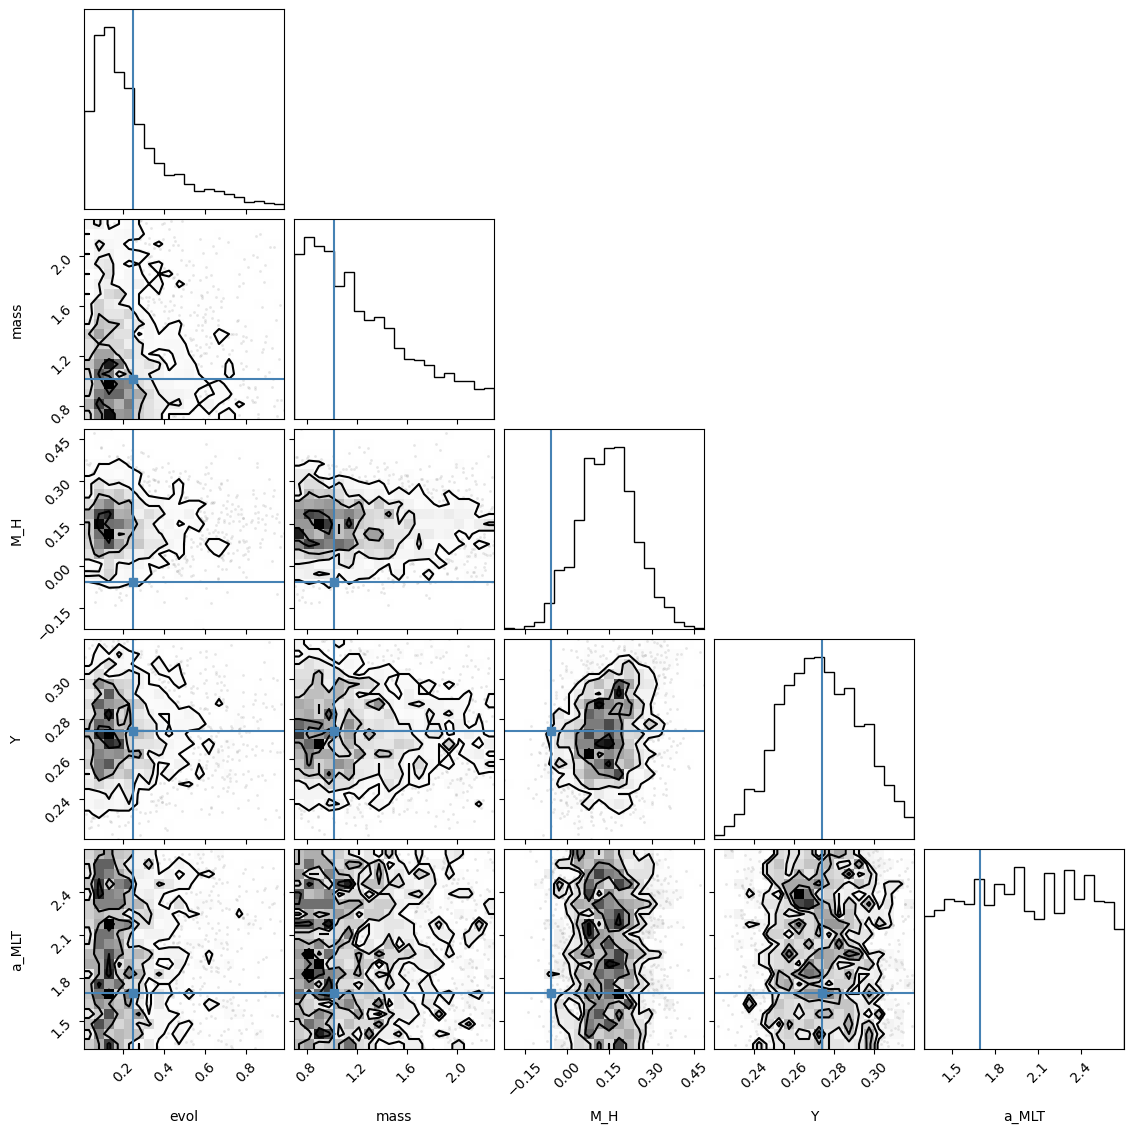

In [36]:
star = 0
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

Let's also look at some determinisitc parameters in the model.

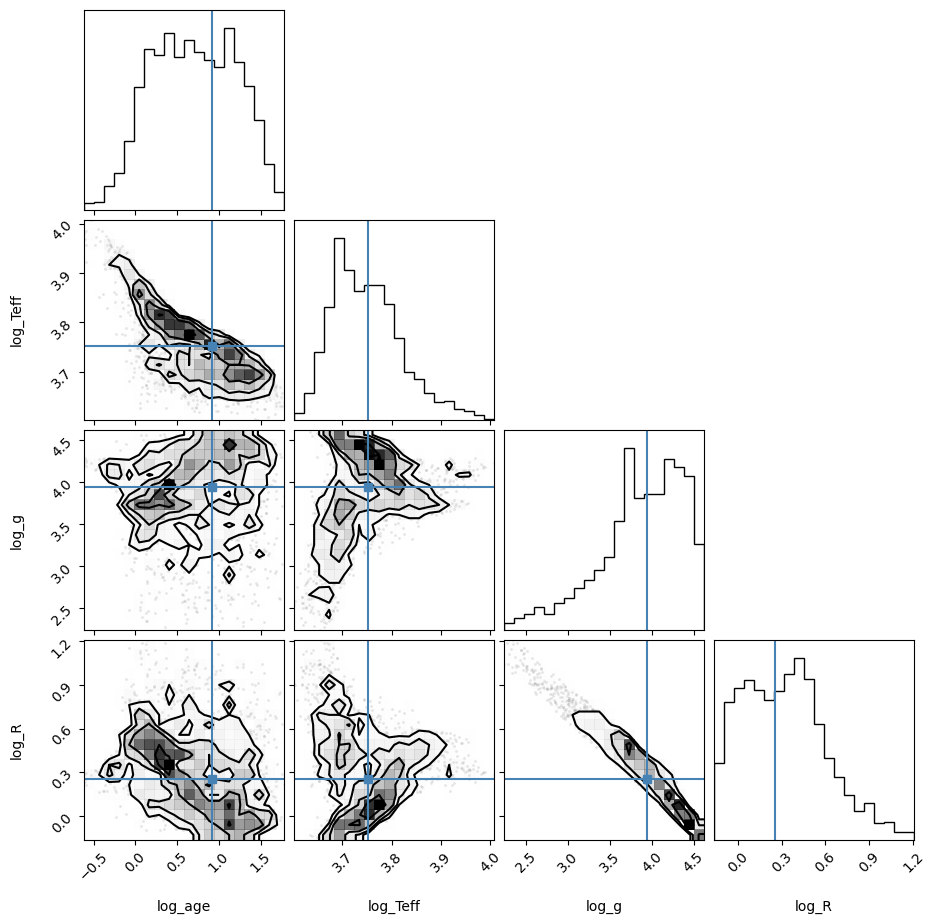

In [37]:
star = 0
var_names = ["log_age", "log_Teff", "log_g", "log_R"]
coords_ = {"star": star}
truths_ = {key: truths[key][star] for key in var_names}
fig = corner(data, group="prior", var_names=var_names, truths=truths_, coords=coords_)

## Observation

Now we synthesize observable parameters for the model.

In [38]:
rng, *keys = random.split(rng, 3)
obs = {
    "Teff": truths["Teff"] + const["Teff"]["scale"] * random.normal(keys[0], shape=truths["Teff"].shape),
    "log_g": truths["log_g"] + const["log_g"]["scale"] * random.normal(keys[1], shape=truths["log_g"].shape),
}
pprint(obs)

{'Teff': Array([ 5689.298 ,  4546.089 ,  5108.7314,  6588.671 ,  5264.273 ,
        5761.563 ,  9102.156 ,  6305.233 ,  8594.421 ,  5060.062 ,
        4889.5176,  4170.694 ,  5328.174 ,  6522.149 ,  4858.8403,
        5726.2812,  5264.221 ,  5818.248 ,  8438.315 ,  7269.196 ,
        9047.177 ,  5058.0884,  6128.05  ,  4537.914 ,  6462.627 ,
        4118.2554,  5099.5156,  7395.39  ,  6453.3794,  9461.907 ,
        4704.388 ,  6757.022 ,  5765.7007,  6982.73  ,  9256.361 ,
        7415.869 ,  5070.025 ,  6593.5903,  5452.0654,  6250.2   ,
        4723.7295,  5391.555 ,  6585.6646,  4549.4014,  5832.486 ,
        5492.8545,  5281.6665,  5822.1934,  5981.072 ,  6409.632 ,
        5742.0654,  5413.4805,  8348.565 ,  5768.2163,  6515.2363,
        4772.904 , 10711.825 ,  6695.635 ,  6815.374 ,  7078.835 ,
        8410.95  ,  6012.0425,  6409.0728,  6173.7285,  4354.0303,
        4257.033 ,  4835.8203,  6608.358 ,  5815.2246,  6212.655 ,
        4835.485 ,  6102.086 ,  6899.827 ,  6498.1445

## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [39]:
sampler = NUTS(model, target_accept_prob=0.8)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=2)

Let's run the MCMC and print a summary of results.

In [40]:
rng, key = random.split(rng)
mcmc.run(key, obs=obs)
mcmc.print_summary()

/home/alex/miniconda3/envs/celestify-cuda/lib/python3.10/site-packages/jax/_src/linear_util.py:191: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  ans = self.f(*args, **dict(self.params, **kwargs))



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
          M_H[0]      0.15      0.10      0.15     -0.02      0.31    827.49      1.01
          M_H[1]      0.22      0.09      0.22      0.07      0.38   1030.48      1.00
          M_H[2]      0.42      0.06      0.43      0.33      0.50   1536.39      1.00
          M_H[3]      0.03      0.09      0.03     -0.13      0.17    988.45      1.00
          M_H[4]      0.06      0.10      0.06     -0.09      0.24    707.17      1.00
          M_H[5]     -0.30      0.10     -0.30     -0.46     -0.15   1218.25      1.00
          M_H[6]     -0.60      0.10     -0.60     -0.75     -0.43   1155.75      1.01
          M_H[7]     -0.52      0.10     -0.52     -0.69     -0.36    968.35      1.00
          M_H[8]     -0.29      0.09     -0.29     -0.45     -0.14    883.20      1.00
          M_H[9]     -0.05      0.10     -0.05     -0.20      0.12    911.39      1.00
         M_H[10]     -0.20      0.10     -

Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

**Note:** The `MultiStarModel` takes longer than running `SingleStarModel` sequentially, but includes population-level priors. It's worth looking at other ways to do this faster.

Let's update our `InferenceData`.

In [41]:
data += az.from_numpyro(mcmc, coords=coords, dims=dims)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> observed_data

With `arviz`, we can create a summary of the data.

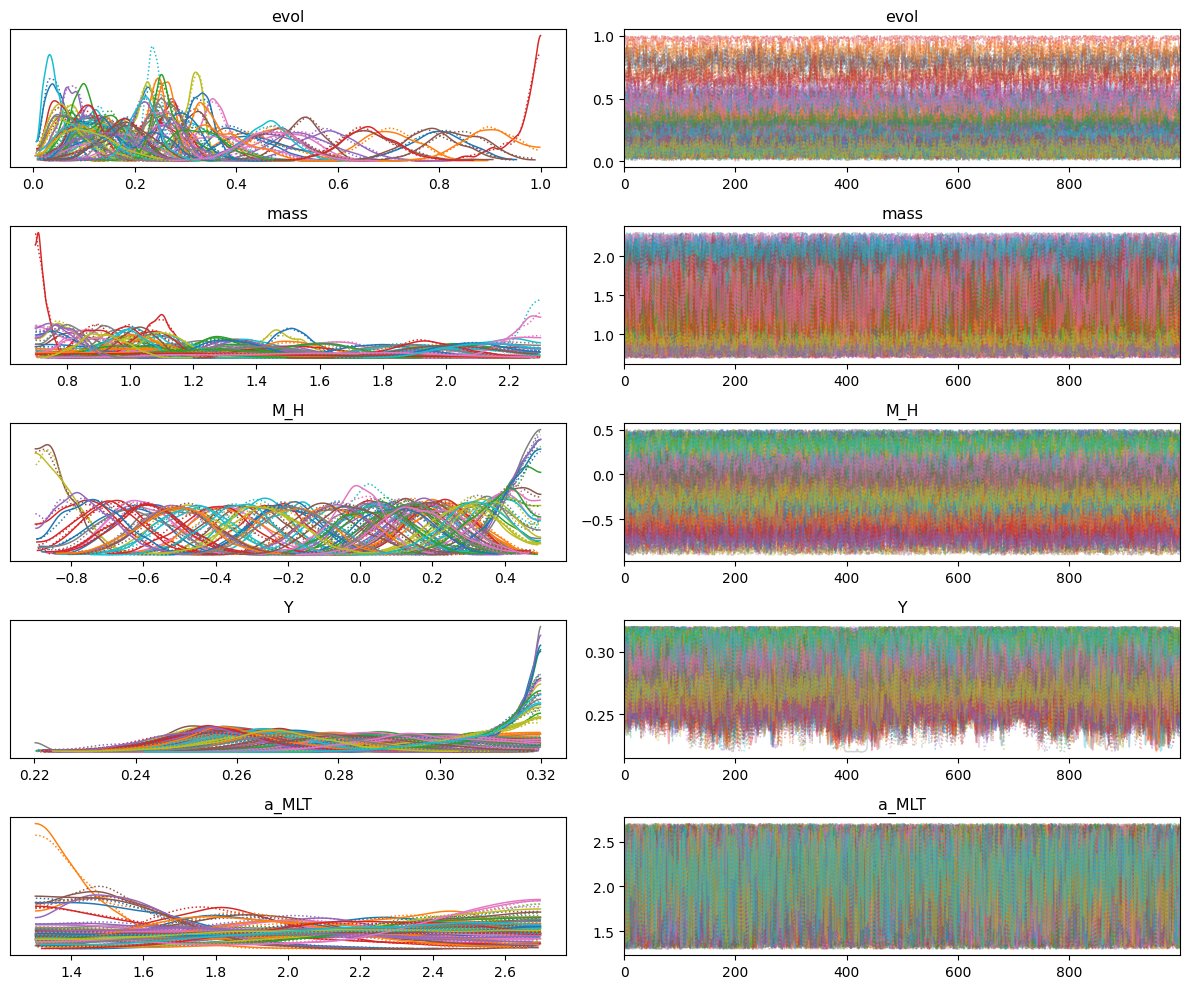

In [42]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
az.plot_trace(data, var_names=var_names)
plt.tight_layout()

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

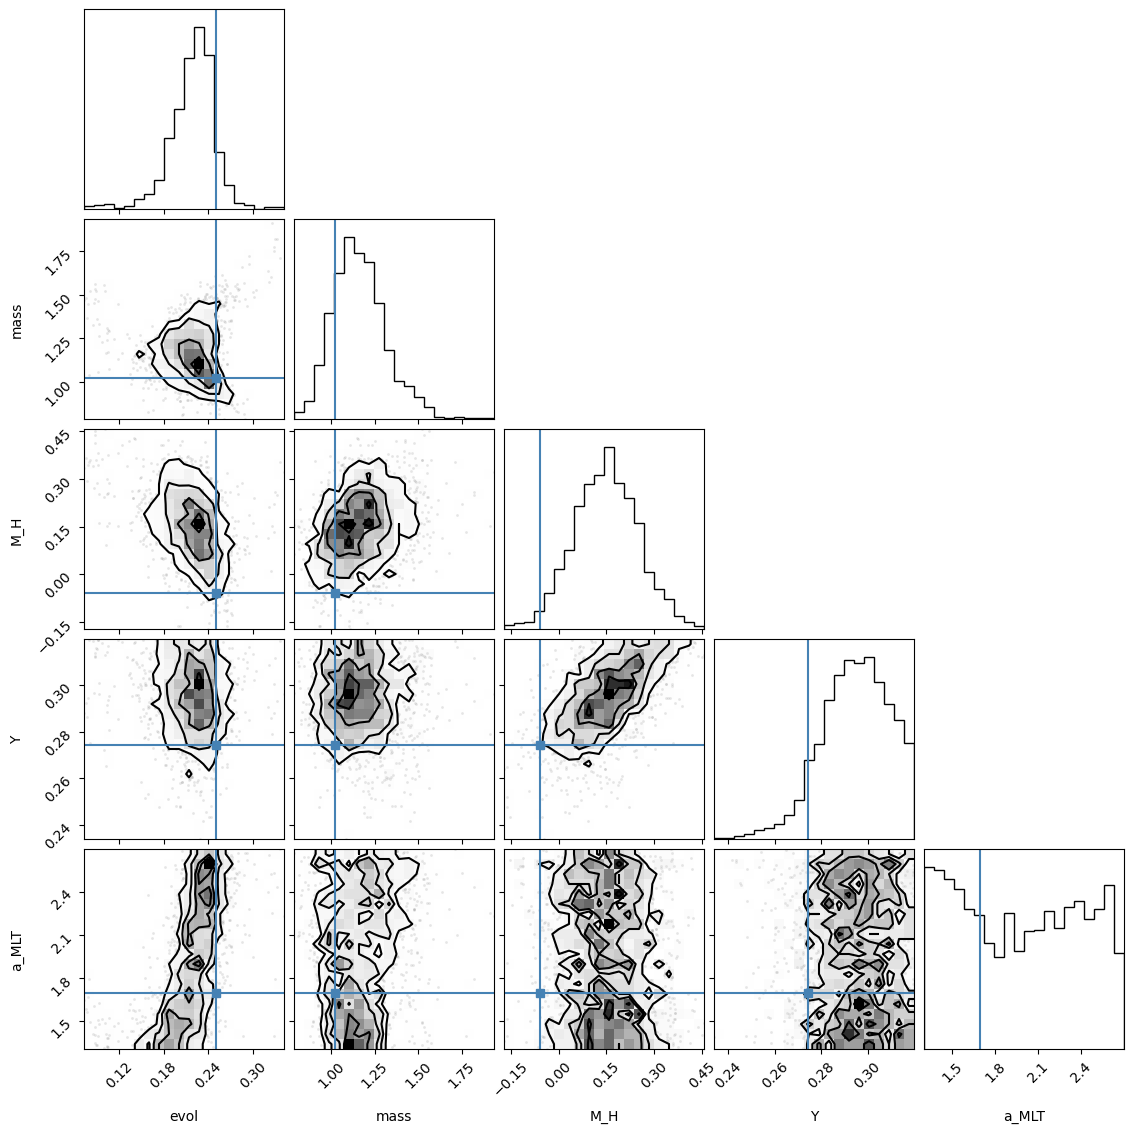

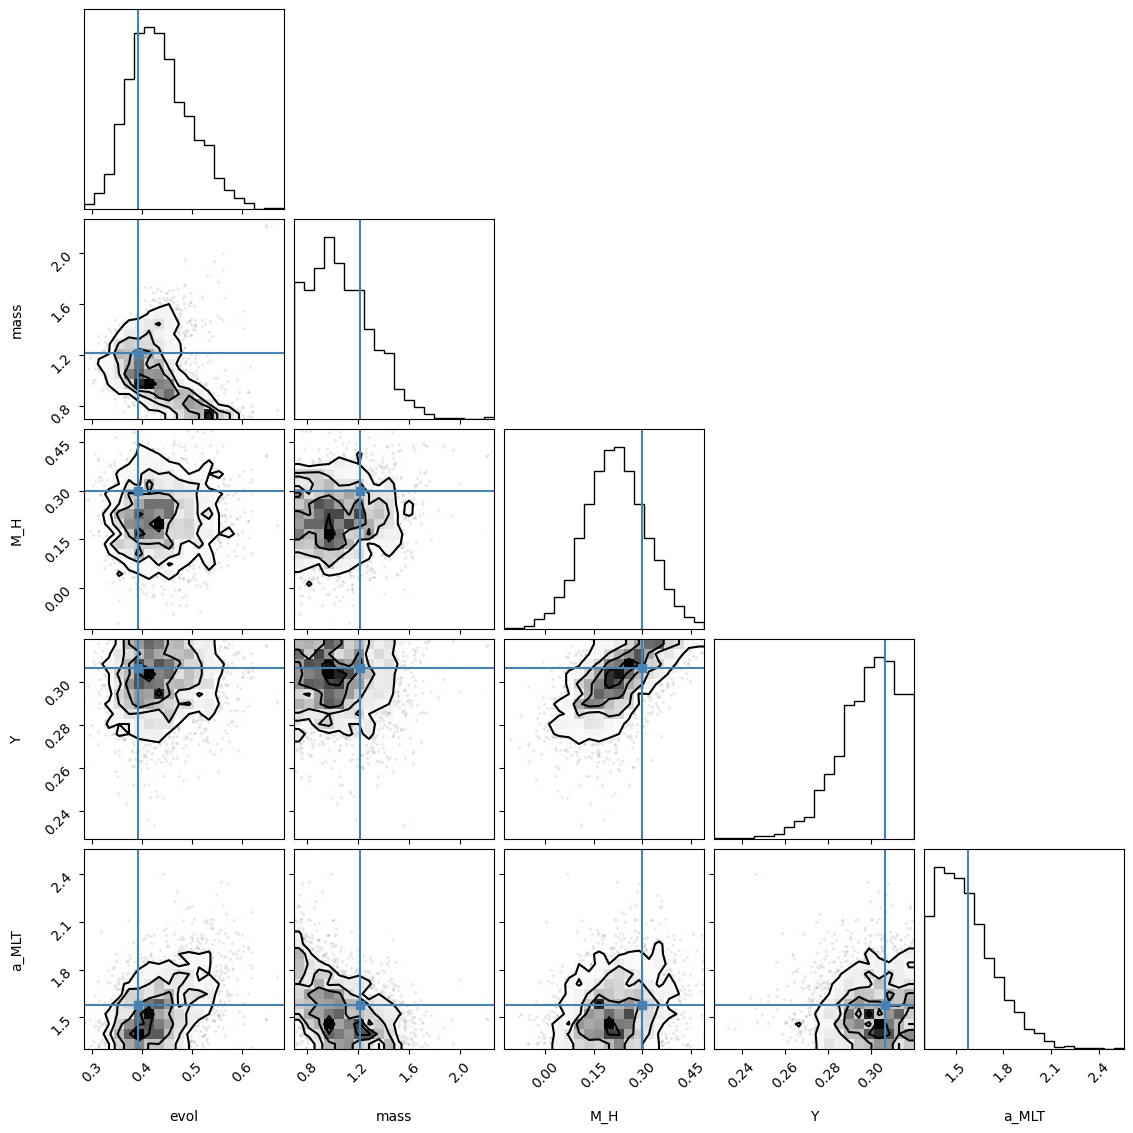

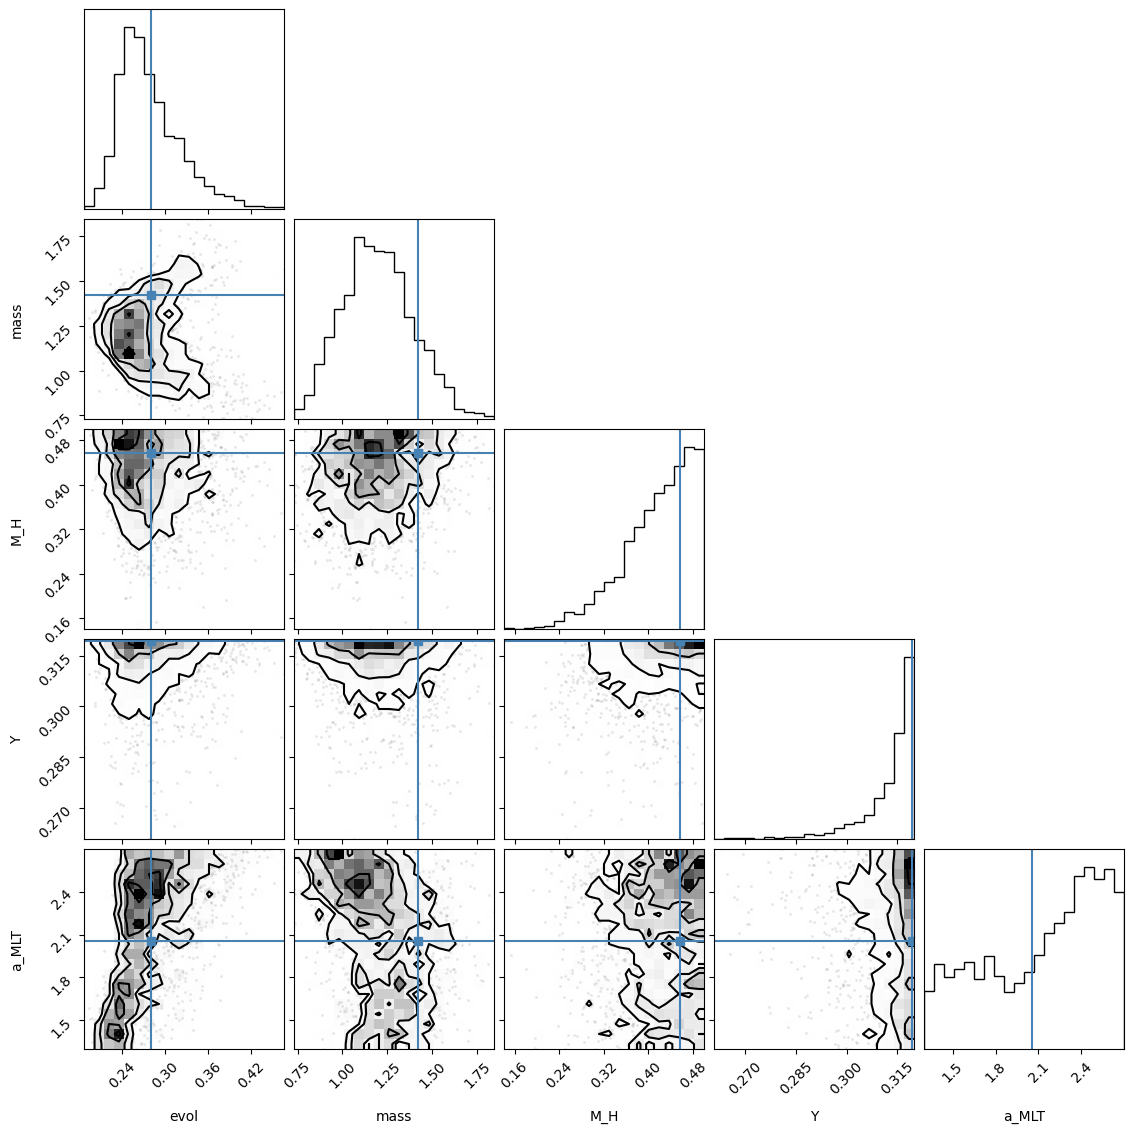

In [45]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

What do we predict for some deterministics?

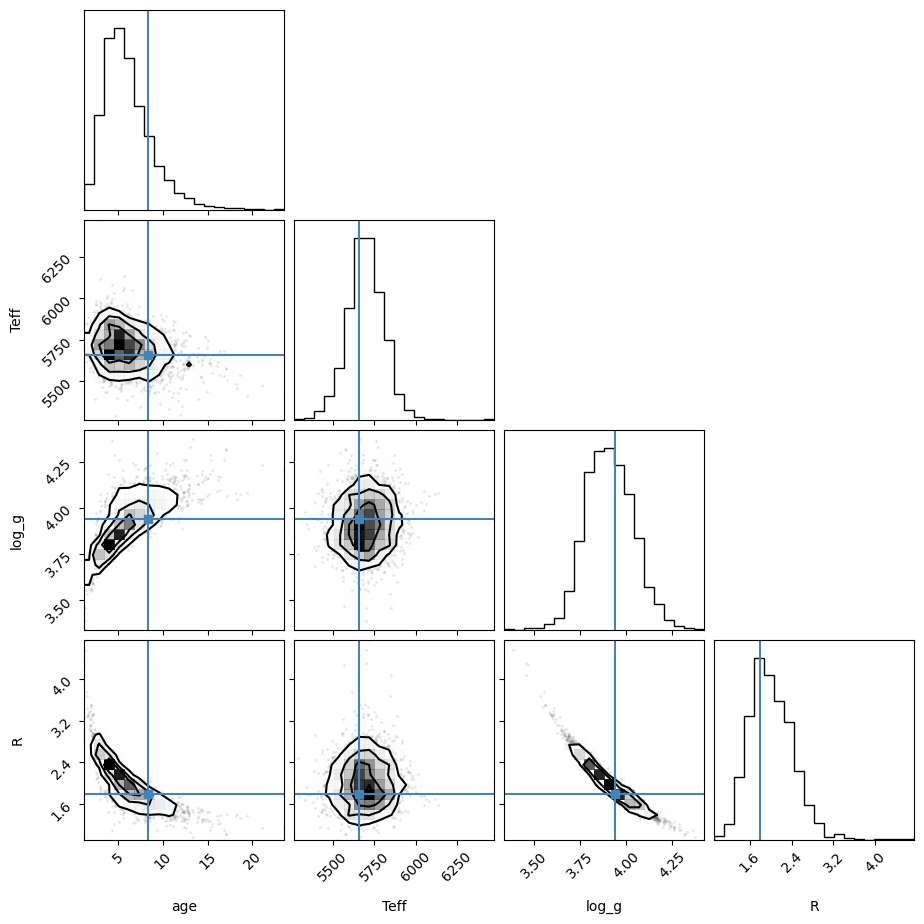

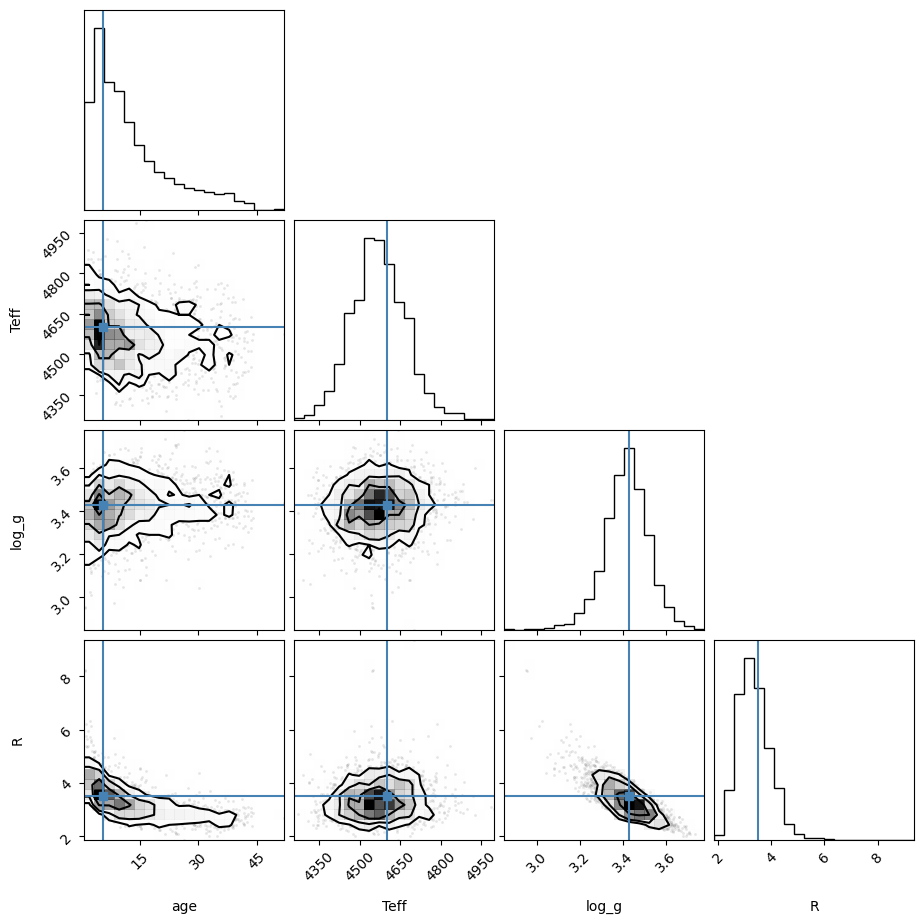

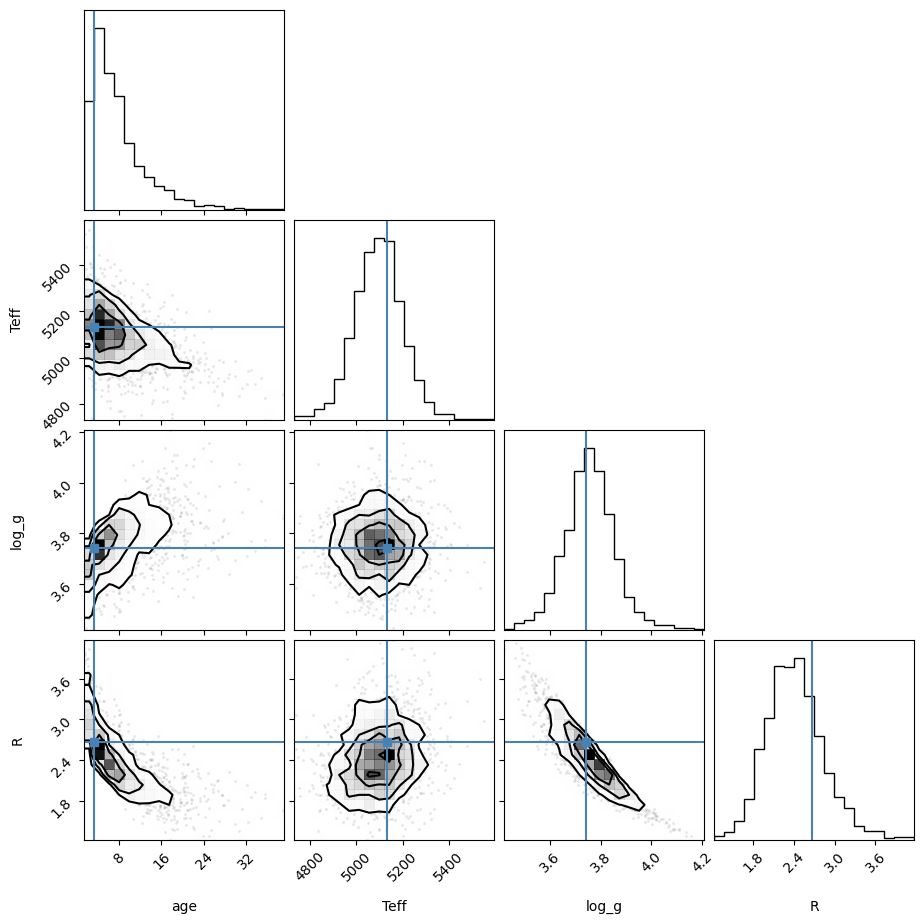

In [46]:
var_names = ["age", "Teff", "log_g", "R"]
for star in range(3):
    coords_ = {"star": star}
    truths_ = {key: truths[key][star] for key in var_names}
    fig = corner(data, group="posterior", var_names=var_names, truths=truths_, coords=coords_)

Let's look at the fractional error between each posterior sample and the truth. This gives us an idea of the precision and accuracy of our results. Don't expect anything impressive, we are marginalising over `Y` and `a_MLT` after all.

In [22]:
error = truths - data.posterior
az.summary(error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]    0.072  0.092  -0.103    0.244      0.002    0.002    1700.0   
M_H[1]    0.083  0.098  -0.097    0.272      0.002    0.002    2244.0   
M_H[2]    0.068  0.102  -0.110    0.270      0.003    0.002    1295.0   
M_H[3]    0.023  0.090  -0.141    0.191      0.002    0.002    1491.0   
M_H[4]   -0.076  0.099  -0.260    0.112      0.003    0.003     871.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[15] -0.003  0.395  -0.761    0.566      0.014    0.013     903.0   
mass[16] -0.134  0.148  -0.400    0.151      0.005    0.004     864.0   
mass[17]  0.349  0.376  -0.374    0.875      0.013    0.009     898.0   
mass[18]  0.039  0.374  -0.674    0.546      0.013    0.011     874.0   
mass[19]  0.001  0.036  -0.063    0.049      0.001    0.001    1397.0   

          ess_tail  r_hat  
M_H[0]      1145.0   1.00  
M_H[1]      1373.0   1.00  
M_H[2]       528.0   1.00  
M_H[3]      1283.0   1.00  
M_H[4]       957.0   1.00  
...            ...    ...  
mass[15]     700.0   1.01  
mass[16]     728.0   1.00  
mass[17]     782.0   1.00  
mass[18]     800.0   1.00  
mass[19]    1093.0   1.00  

[320 rows x 9 columns]

In [23]:
fractional_error = (truths - data.posterior) / truths
az.summary(fractional_error)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
M_H[0]    0.512  0.649  -0.732    1.730      0.016    0.012    1700.0   
M_H[1]   -0.377  0.448  -1.235    0.443      0.009    0.009    2244.0   
M_H[2]    0.290  0.431  -0.468    1.143      0.012    0.009    1295.0   
M_H[3]   -0.248  0.955  -2.029    1.495      0.025    0.019    1491.0   
M_H[4]   -0.955  1.250  -3.276    1.417      0.042    0.032     871.0   
...         ...    ...     ...      ...        ...      ...       ...   
mass[15] -0.003  0.312  -0.601    0.447      0.011    0.010     903.0   
mass[16] -0.082  0.090  -0.244    0.092      0.003    0.003     864.0   
mass[17]  0.221  0.239  -0.237    0.556      0.008    0.006     898.0   
mass[18]  0.031  0.300  -0.541    0.438      0.011    0.009     874.0   
mass[19]  0.002  0.048  -0.084    0.066      0.001    0.001    1397.0   

          ess_tail  r_hat  
M_H[0]      1145.0   1.00  
M_H[1]      1373.0   1.00  
M_H[2]       528.0   1.00  
M_H[3]      1283.0   1.00  
M_H[4]       957.0   1.00  
...            ...    ...  
mass[15]     700.0   1.01  
mass[16]     728.0   1.00  
mass[17]     782.0   1.00  
mass[18]     800.0   1.00  
mass[19]    1093.0   1.00  

[320 rows x 9 columns]

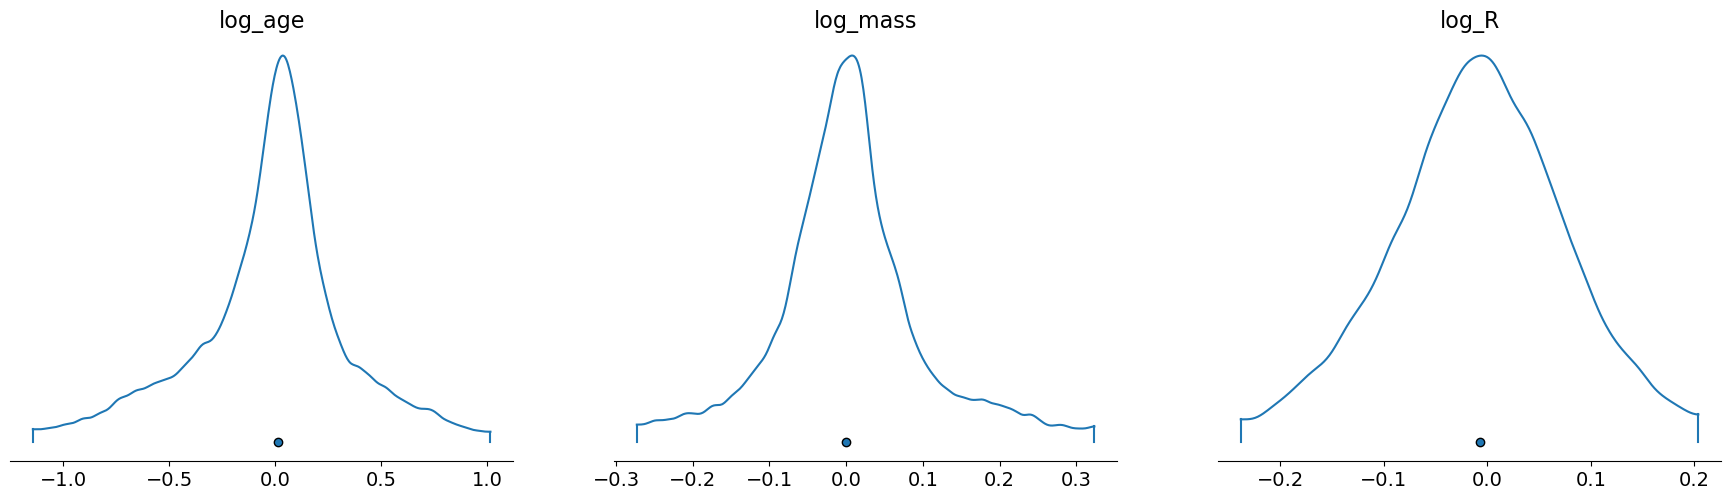

In [26]:
az.plot_density(error, var_names=["log_age", "log_mass", "log_R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);

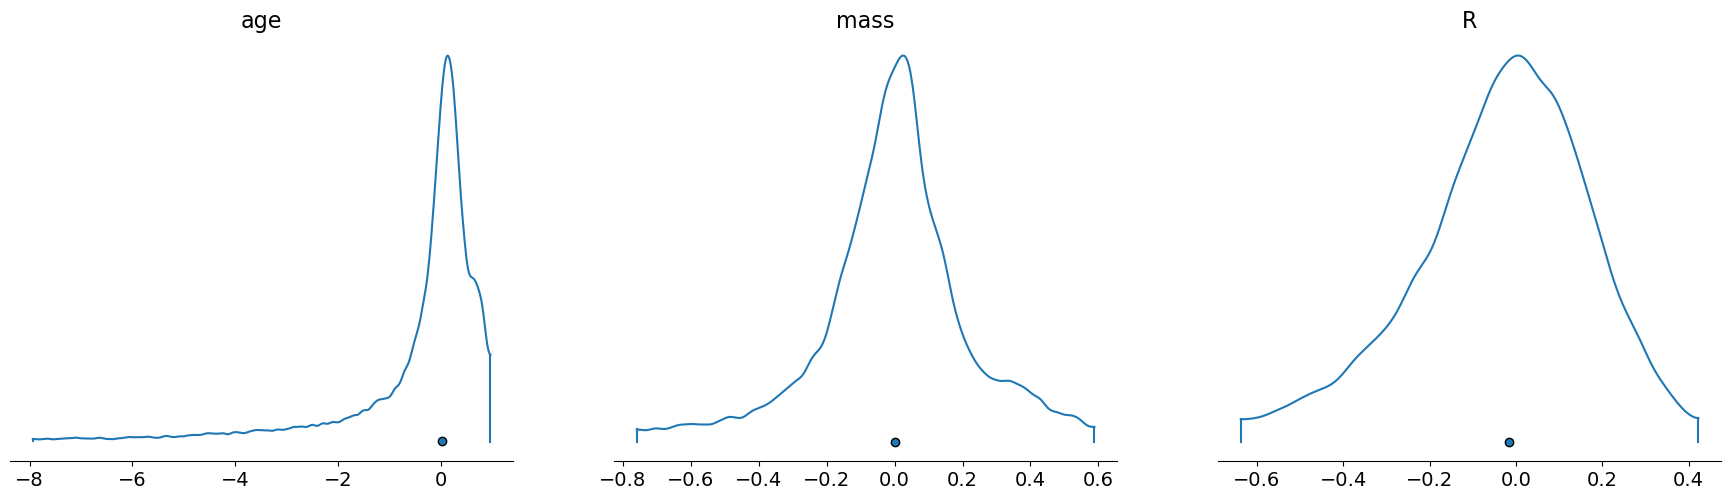

In [27]:
az.plot_density(fractional_error, var_names=["age", "mass", "R"], combine_dims={"star"}, 
                point_estimate="median", hdi_prob=0.98);